<a href="https://colab.research.google.com/github/ronv3/spotify-song-recommendations/blob/master/popularity_prediction_balanced_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV

'''
from google.colab import drive
drive.mount('/content/drive')
pathway = '/content/drive/MyDrive/Colab Notebooks/'
data = pd.read_csv(pathway+"KaggleDataset.csv")
'''
data = pd.read_csv("KaggleDataset.csv")

Mounted at /content/drive


In [4]:
# Drop rows with missing values
data = data.dropna()
data.shape

(113999, 21)

In [5]:
data['is_hit'] = (data['popularity'] > 75).astype(int)

# Separate the dataset into two classes
popular_songs = data[data['is_hit'] == 1]
unpopular_songs = data[data['is_hit'] == 0]

# Downsample the majority class (unpopular songs)
unpopular_sampled = unpopular_songs.sample(n=len(popular_songs), random_state=42)

# Combine the balanced dataset
balanced_data = pd.concat([popular_songs, unpopular_sampled])

# Shuffle the dataset
balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)
balanced_data.shape

X = pd.get_dummies(balanced_data.drop(columns=['popularity', 'is_hit', 'track_id', 'album_name', 'track_name', 'track_genre', 'artists'], errors='ignore'))
y = balanced_data['is_hit']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=20, stratify=y)

print("Training Class Distribution:", y_train.value_counts())
print("Test Class Distribution:", y_test.value_counts())

Training Class Distribution: is_hit
0    2173
1    2172
Name: count, dtype: int64
Test Class Distribution: is_hit
1    242
0    241
Name: count, dtype: int64


### Random Forest Model

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.93      0.89       241
           1       0.92      0.85      0.88       242

    accuracy                           0.89       483
   macro avg       0.89      0.89      0.89       483
weighted avg       0.89      0.89      0.89       483

AUC-ROC: 0.93


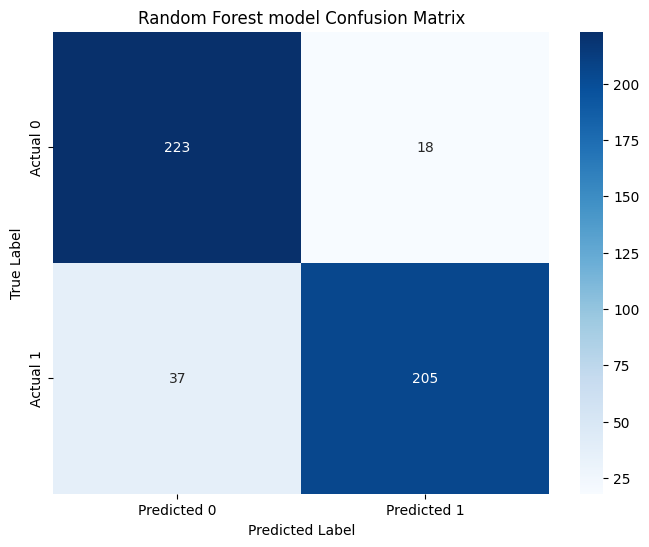

In [12]:
# Initialize and train the model
model = RandomForestClassifier(random_state=21, n_estimators=100)
model.fit(X_train, y_train)

# Predict on the test set
#y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]
threshold = 0.6  # Adjust to a lower threshold
y_pred_thresholded = (y_pred_proba >= threshold).astype(int)

# Evaluate the model
classification_rep = classification_report(y_test, y_pred_thresholded)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_thresholded)

# Display metrics and confusion matrix
print("Classification Report:")
print(classification_rep)
print(f"AUC-ROC: {roc_auc:.2f}")

# Plot the confusion matrix using seaborn and matplotlib
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title("Random Forest model Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Recall: 85%
Precision: 92%

### Linear SVM

In [7]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, roc_auc_score

In [8]:
# Standardize features and use LinearSVC
svm_model = make_pipeline(StandardScaler(), LinearSVC(class_weight={0: 0.51, 1: 23.61}, random_state=42, max_iter=10000))

# Fit the model on the training data
svm_model.fit(X_train, y_train)

# Predict on the test set
#y_pred = svm_model.predict(X_test) # Adjusting threshold decreases recall, so not implementing that
threshold = 0.6  # Adjust to a lower threshold
y_pred_thresholded = (y_pred_proba >= threshold).astype(int)

# Linear SVM does not provide probabilities directly, but we can use the decision function
y_scores = svm_model.decision_function(X_test)

# Evaluate the model
classification_rep = classification_report(y_test, y_pred_thresholded)
roc_auc = roc_auc_score(y_test, y_scores)

print("Classification Report (Linear SVM):")
print(classification_rep)
print(f"AUC-ROC: {roc_auc:.2f}")

Classification Report (Linear SVM):
              precision    recall  f1-score   support

           0       0.86      0.93      0.89       241
           1       0.92      0.85      0.88       242

    accuracy                           0.89       483
   macro avg       0.89      0.89      0.89       483
weighted avg       0.89      0.89      0.89       483

AUC-ROC: 0.76


Recall: 85%
Precision: 92%

### K-nearest neighbors¶

In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, roc_auc_score

In [10]:
# Standardize features and use KNN
knn_model = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=5, weights='distance'))

# Fit the model on the training data
knn_model.fit(X_train, y_train)

# Predict on the test set
#y_pred = knn_model.predict(X_test)
threshold = 0.46  # Threshold helps but not enough
y_pred_thresholded = (y_pred_proba >= threshold).astype(int)

# Predict probabilities (for AUC-ROC)
y_pred_proba = knn_model.predict_proba(X_test)[:, 1]

# Evaluate the model
classification_rep = classification_report(y_test, y_pred_thresholded)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("Classification Report (K-Nearest Neighbors):")
print(classification_rep)
print(f"AUC-ROC: {roc_auc:.2f}")

Classification Report (K-Nearest Neighbors):
              precision    recall  f1-score   support

           0       0.89      0.76      0.82       241
           1       0.79      0.91      0.85       242

    accuracy                           0.84       483
   macro avg       0.84      0.84      0.84       483
weighted avg       0.84      0.84      0.84       483

AUC-ROC: 0.82


Recall: 85%
Precision: 70%

# Results
### Models in order based on performance

1. Random Forest (R: 85%, P: 92%)
3. Linear SVM (R: 85%, P: 92%)
4. K-nearest neighbors (R: 85%, P: 70%)